#Imports, global variables en inleiding

Werking:
1.   Verander de variabelen naar wat er gewenst wordt.
2.   Fabrieksinstellingen terugzetten van de runtime.
3.   Alles uitvoeren.
4.   Wacht tot alles uitgevoerd werd.
5.   Bekijk de resultaten. 

Toegepaste modellen:
1.   Simpel neuraal netwerk.
2.   Simpel model met een data-augmentation layer.
3.   VGG16 model met een data-augmentation layer.

*Uitwerking van eigen bevindingen staan in caseverslag (te vinden op google drive).

**In elk scenario met twee painters gaf VGG16 het beste resultaat, zonder enige vorm van sampling strategie.

In [ ]:
#Variabelen:
Train_Simple = True
TS_epochs = 30
Train_Simple_DA = True
TSDA_epochs = 30
Train_VGG16 = True
TVGG16_epochs = 10
painters = ["Mondriaan","Picasso"]
sampling_method = "none" #none lijkt telkens het beste resultaat terug te geven. Uitwerking in caseverslag te zien.
Paintings_Retrieval_Module_Path = "gdrive/MyDrive/Colab Notebooks/DL_Paintings_Retrieve.ipynb"

In [ ]:
from google.colab import drive
import os
import shutil
import pickle
import numpy as np
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras 
from tensorflow.keras import layers  
import matplotlib.pyplot as plt

drive.mount("/content/gdrive")
shutil.copyfile(Paintings_Retrieval_Module_Path,os.getcwd()+"/DL_Paintings_Retrieve.ipynb")

Mounted at /content/gdrive


'/content/DL_Paintings_Retrieve.ipynb'

In [ ]:
!pip install import-ipynb
import import_ipynb
import DL_Paintings_Retrieve as data_r

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-py3-none-any.whl size=2975 sha256=14eb38f7b422dc450e36fa739b30a8c58a71a4ea10f52c5ec7315ea6d6dfaa4c
  Stored in directory: /root/.cache/pip/wheels/b1/5e/dc/79780689896a056199b0b9f24471e3ee184fbd816df355d5f0
Successfully built import-ipynb
importing Jupyter notebook from DL_Paintings_Retrieve.ipynb
     |████████████████████████████████| 77 kB 3.3 MB/s 


Data retrieval module oproepen + opzetten van environment voor modellen

In [ ]:
data_manager = data_r.Data_Setup(painters=painters, resize_mode="none", sampling_method=sampling_method)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
patool: Extracting Mondriaan.rar ...
patool: running /usr/bin/unrar x -- /content/Mondriaan.rar
patool:     with cwd='Input'
patool: ... Mondriaan.rar extracted to `Input'.
patool: Extracting Picasso.rar ...
patool: running /usr/bin/unrar x -- /content/Picasso.rar
patool:     with cwd='Input'
patool: ... Picasso.rar extracted to `Input'.

No resize done.

---- Mondriaan ----
{'Train': 231, 'Test': 33, 'Val': 66}
---- Picasso ----
{'Train': 1070, 'Test': 153, 'Val': 306}


Copying files: 1859 files [00:02, 918.50 files/s] 


In [ ]:
shape = tuple(data_manager.get_shape_avg())

Mondriaan
Picasso
Mondriaan
Picasso


In [ ]:
train_dataset = image_dataset_from_directory(
    "Datasets/train",
    image_size=shape,
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    "Datasets/val",
    image_size=shape,
    batch_size=32)
test_dataset = image_dataset_from_directory(
    "Datasets/test",
    image_size=shape,
    batch_size=32)

Found 1300 files belonging to 2 classes.
Found 185 files belonging to 2 classes.
Found 374 files belonging to 2 classes.


#Helper code

Dit is code die voor elk algoritme hetzelfde is.

In [ ]:
def start_training(model, filename, epochs=30):
  callbacks = [
      keras.callbacks.ModelCheckpoint(
          filepath=filename+".keras",
          save_best_only=True,
          monitor="val_loss")
  ]
  history = model.fit(
      train_dataset,
      epochs=epochs,
      validation_data=validation_dataset,
      callbacks=callbacks)
  return history

In [ ]:
def plot_results(history):
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  epochs = range(1, len(accuracy) + 1)
  plt.plot(epochs, accuracy, "bo", label="Training accuracy")
  plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
  plt.title("Training and validation accuracy")
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, "bo", label="Training loss")
  plt.plot(epochs, val_loss, "b", label="Validation loss")
  plt.title("Training and validation loss")
  plt.legend()
  plt.show()

In [ ]:
def test_model(alg_filename):
  test_model = keras.models.load_model(alg_filename+".keras")
  test_loss, test_acc = test_model.evaluate(test_dataset) 
  print(f"Test accuracy: {test_acc:.3f}")

In [ ]:
def save_model(savename, model):
  filename = savename+".sav"
  pickle.dump(model, open(filename, 'wb'))

In [ ]:
def load_model(savename):
  return pickle.load(savename)

#DL Model 1: Simpel (cursus)

In [ ]:
def construct_simple_model():  
  inputs = keras.Input(shape=(shape[0], shape[1], 3))
  x = layers.Rescaling(1./255)(inputs)
  x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Flatten()(x)
  outputs = layers.Dense(1, activation="sigmoid")(x)
  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(loss="binary_crossentropy",
                optimizer="rmsprop",
                metrics=["accuracy"])
  return model


---- Training & testing of simple model for two painters ----


---- Training ----

Epoch 1/30
41/41 [==============================] - 82s 1s/step - loss: 1.6451 - accuracy: 0.7869 - val_loss: 0.4566 - val_accuracy: 0.8216
Epoch 2/30
41/41 [==============================] - 44s 1s/step - loss: 0.5107 - accuracy: 0.8077 - val_loss: 0.4346 - val_accuracy: 0.8216
Epoch 3/30
41/41 [==============================] - 43s 997ms/step - loss: 0.4716 - accuracy: 0.8246 - val_loss: 0.4789 - val_accuracy: 0.8216
Epoch 4/30
41/41 [==============================] - 43s 992ms/step - loss: 0.4516 - accuracy: 0.8131 - val_loss: 0.8220 - val_accuracy: 0.8216
Epoch 5/30
41/41 [==============================] - 43s 998ms/step - loss: 0.4038 - accuracy: 0.8192 - val_loss: 0.2999 - val_accuracy: 0.8378
Epoch 6/30
41/41 [==============================] - 43s 1s/step - loss: 0.3571 - accuracy: 0.8500 - val_loss: 0.2731 - val_accuracy: 0.8919
Epoch 7/30
41/41 [==============================] - 43s 998ms/step

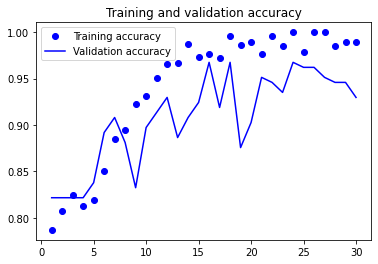

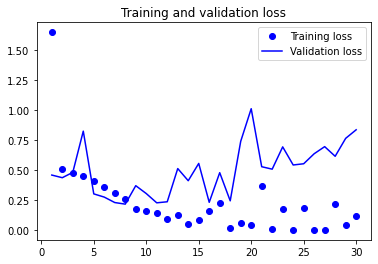


---- Test ----

12/12 [==============================] - 12s 841ms/step - loss: 0.2730 - accuracy: 0.8690
Test accuracy: 0.869


In [ ]:
if Train_Simple:
  print("\n---- Training & testing of simple model for two painters ----\n")
  filename = "2P_simple"
  P2_S_model = construct_simple_model()
  print("\n---- Training ----\n")
  history = start_training(P2_S_model, filename, epochs=TS_epochs)
  print("\n---- Results ----\n")
  plot_results(history)
  print("\n---- Test ----\n")
  test_model(filename)
else:
  print("\n---- Training & testing of simple model for two painters skipped----\n")

#DL Model 2: Data augmentation + Simpel (cursus)

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

def construct_simple_model_DA():
  inputs = keras.Input(shape=(shape[0], shape[1], 3))
  x = data_augmentation(inputs)
  x = layers.Rescaling(1./255)(inputs)
  x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
  x = layers.Flatten()(x)
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(1, activation="sigmoid")(x)
  model = keras.Model(inputs=inputs, outputs=outputs)
  
  model.compile(loss="binary_crossentropy",
                optimizer="rmsprop",
                metrics=["accuracy"])
  
  return model


---- Training & testing of simple model for two painters with data augmentation ----


---- Training ----

Epoch 1/30
41/41 [==============================] - 44s 999ms/step - loss: 1.2264 - accuracy: 0.8092 - val_loss: 0.5061 - val_accuracy: 0.8216
Epoch 2/30
41/41 [==============================] - 43s 988ms/step - loss: 0.4741 - accuracy: 0.8215 - val_loss: 0.7177 - val_accuracy: 0.5838
Epoch 3/30
41/41 [==============================] - 43s 985ms/step - loss: 0.5445 - accuracy: 0.8131 - val_loss: 0.8740 - val_accuracy: 0.8216
Epoch 4/30
41/41 [==============================] - 42s 985ms/step - loss: 0.4902 - accuracy: 0.8238 - val_loss: 0.4168 - val_accuracy: 0.8216
Epoch 5/30
41/41 [==============================] - 43s 991ms/step - loss: 0.3939 - accuracy: 0.8223 - val_loss: 0.3233 - val_accuracy: 0.8432
Epoch 6/30
41/41 [==============================] - 43s 986ms/step - loss: 0.3684 - accuracy: 0.8346 - val_loss: 0.2949 - val_accuracy: 0.8919
Epoch 7/30
41/41 [================

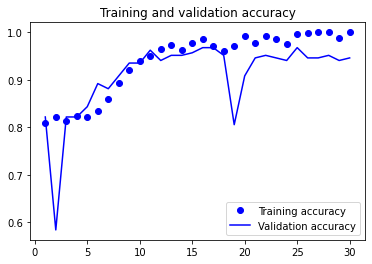

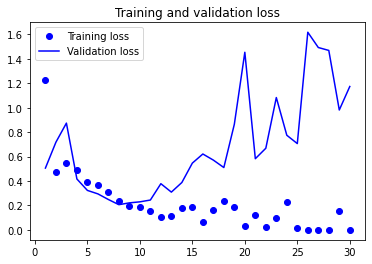


---- Test ----

12/12 [==============================] - 7s 380ms/step - loss: 0.2698 - accuracy: 0.8877
Test accuracy: 0.888


In [ ]:
if Train_Simple_DA:
  print("\n---- Training & testing of simple model for two painters with data augmentation ----\n")
  filename = "2P_simple_DA"
  P2_S_model_DA = construct_simple_model()
  print("\n---- Training ----\n")
  history = start_training(P2_S_model_DA, filename, epochs=TSDA_epochs)
  print("\n---- Results ----\n")
  plot_results(history)
  print("\n---- Test ----\n")
  test_model(filename)
else:
  print("\n---- Training & testing of simple model for two painters with data augmentation skipped ----\n")

#DL Model 3: VGG16 + DA

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
weights="imagenet",
include_top=False
)
conv_base.trainable = False

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
def construct_VGG16_DA_model():
  data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
  )
  
  inputs = keras.Input(shape=(shape[0], shape[1], 3))
  x = data_augmentation(inputs)
  x = keras.applications.vgg16.preprocess_input(x)
  x = conv_base(x)
  x = layers.Flatten()(x)
  x = layers.Dense(256)(x)
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(1, activation="sigmoid")(x)
  model = keras.Model(inputs, outputs)
  model.compile(loss="binary_crossentropy",
                optimizer="rmsprop",
                metrics=["accuracy"])

  return model


---- Training & testing of VGG16 model for two painters ----


---- Training ----

Epoch 1/10
41/41 [==============================] - 250s 5s/step - loss: 85.5479 - accuracy: 0.8846 - val_loss: 7.9186 - val_accuracy: 0.9784
Epoch 2/10
41/41 [==============================] - 113s 3s/step - loss: 31.6163 - accuracy: 0.9415 - val_loss: 13.6455 - val_accuracy: 0.9676
Epoch 3/10
41/41 [==============================] - 115s 3s/step - loss: 26.2013 - accuracy: 0.9546 - val_loss: 3.2989 - val_accuracy: 0.9730
Epoch 4/10
41/41 [==============================] - 115s 3s/step - loss: 10.9738 - accuracy: 0.9785 - val_loss: 3.2243 - val_accuracy: 0.9784
Epoch 5/10
41/41 [==============================] - 113s 3s/step - loss: 14.1207 - accuracy: 0.9715 - val_loss: 6.3910 - val_accuracy: 0.9838
Epoch 6/10
41/41 [==============================] - 113s 3s/step - loss: 12.4441 - accuracy: 0.9746 - val_loss: 5.4114 - val_accuracy: 0.9838
Epoch 7/10
41/41 [==============================] - 113s 3s/ste

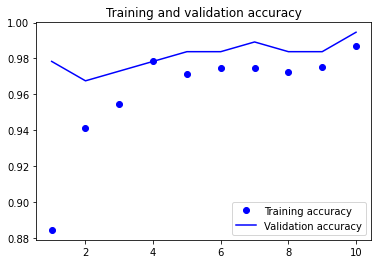

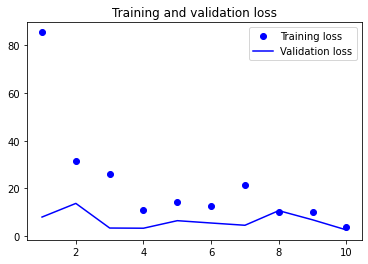


---- Test ----

12/12 [==============================] - 65s 5s/step - loss: 8.3337 - accuracy: 0.9679
Test accuracy: 0.968


In [ ]:
if Train_VGG16:
  print("\n---- Training & testing of VGG16 model for two painters ----\n")
  filename = "2P_VGG16"
  P2_VGG16_model_DA = construct_VGG16_DA_model()
  print("\n---- Training ----\n")
  history = start_training(P2_VGG16_model_DA, filename, epochs=TVGG16_epochs)
  print("\n---- Results ----\n")
  plot_results(history)
  print("\n---- Test ----\n")
  test_model(filename)
else:
  print("\n---- Training & testing of VGG16 model for two painters skipped ----\n")